In [1]:
# Cálculo de isoyetas y polígonos de thiessen.

import numpy as np
import pandas as pd

from scipy import spatial

from matplotlib import pyplot as plt

import geopandas as gpd
import shapely as shp

In [2]:
# Dirección de los datos.
path = "../Material/Clases/Clase 11/"

# Nombre de la cuenca.
nombres_sub = "RH19Be_subc.shp"

# Datos de estaciones.
nombre_e = "Estaciones_Guerrero_1980.csv"

In [3]:
# Abrimos la subcuenca.
Subcuenca = gpd.read_file(path + nombres_sub)

# A coordenadas UTM 14N (m).
Subcuenca = Subcuenca.to_crs(32614)

# Abrimos las estaciones ubicadas en guerrero.
df = pd.read_csv(path + nombre_e, index_col = "NUMERO" )

# Creamos un punto con las coordenadas.
# Vacío.
df["geometry"] = None
df["geometry"] = gpd.points_from_xy(df["LONGITUD"], df["LATITUD"])

# Creamos un GeoDataFrame.
Estaciones = gpd.GeoDataFrame(df, geometry = "geometry", crs = 4326)
# A coordenadas UTM 14N (m).
Estaciones = Estaciones.to_crs(32614)

# Actualizamos x, y.
Estaciones["x"] = Estaciones.centroid.x
Estaciones["y"] = Estaciones.centroid.y

# Polígonos de Thiessen

In [4]:
# Agregamos estaciones virtuales en los límites de la extensión de la cuenca.

# Alejamos los puntos de la cuenca para que los nuevos polígonos de Thiessen
# no toquen la cuenca.
buffer = 20000
# Obtenemos la extensión de la cuenta.
bounds = Subcuenca.total_bounds
# Creamos los puntos en las esquinas e intermedio entre cada vértice
# agregando el valor del buffer.
bbox = [ [ bounds[0] - buffer, bounds[1] - buffer ],
         [ ( bounds[0] + bounds[2] ) / 2, bounds[1] - buffer ],
         [ bounds[2] + buffer, bounds[1] - buffer ],
         [ bounds[2] + buffer, ( bounds[1] + bounds[3] ) / 2 ],
         [ bounds[2] + buffer, bounds[3] + buffer ],
         [ ( bounds[0] + bounds[2] ) / 2, bounds[3] + buffer ],
         [ bounds[0] - buffer, bounds[3] + buffer ],
         [ bounds[0] - buffer, ( bounds[1] + bounds[3] ) / 2 ] ]
# Creamos una lista vacía con las geometrías de los puntos.
for i in range( len(bbox) ):
    bbox[i] = ( [f"B{i + 1}"] + [None] * 4
        + [shp.geometry.Point(bbox[i]), bbox[i][0], bbox[i][1] ] )
# Agregamos las estaciones virtuales.
Estaciones = pd.concat([Estaciones,
    pd.DataFrame(bbox, columns = Estaciones.columns)]
    ).reset_index( drop = True )


# Creamos los polígonos de Thiessen.
Thiessen = spatial.Voronoi( Estaciones[ ["x", "y"] ] )

# Extraemos los polígonos de Thiessen, los convertimos en geometrías
# de Shapely y los agregamos al geoDataFrame de Estaciones.

# Creamos los polígonos de Thiessen.
Thiessen = spatial.Voronoi( Estaciones[ ["x", "y"] ] )

# Extraemos los polígonos de Thiessen, los convertimos en geometrías
# de Shapely y los agregamos al geoDataFrame de Estaciones.

# Lista de geometrías de Shapely.
Poly_th = []

# Iteramos para cada lista de vértices que forman un polígono.
for i in Thiessen.point_region:

    # Creamos la lista de vértices.
    Ver_th = []

    # Saltamos las listas vacías.
    if len(Thiessen.regions[i]) == 0: pass
    else:
        if -1 in Thiessen.regions[i]:
            Poly_th.append( shp.geometry.Polygon( ) )
    
        # Agregamos cada vértice que corresponde al polígono de Thiessen.
        else:
            for j in Thiessen.regions[i]:
                Ver_th.append( Thiessen.vertices[j] )

            # Agregamos nuevamente el primer vértice para cerrar el polígono.
            Ver_th.append( Ver_th[0] )

            # Convertimos a geometría de shapely.
            Poly_th.append( shp.geometry.Polygon( Ver_th ) )

# Creamos una columna del GeoDataframe con los polígonos de Thiessen.
Estaciones["Thiessen"] = Poly_th
# Establecemos como la geometría de trabajo.
Estaciones = Estaciones.set_geometry("Thiessen")

# Retiramos las estaciones virtuales.
Estaciones = Estaciones.iloc[:-8].copy()
Estaciones["HP_1980"] = Estaciones["HP_1980"].astype(float)

In [5]:
# Áreas de influencia

# Calculamos el área de influencia de la estación como la parte
# de la cuenca que cae dentro de cada polígono de thiessen.
Estaciones[Subcuenca.loc[0, 'CVE_SUBCUE']] = Estaciones["Thiessen"
    ].intersection( Subcuenca.loc[0, "geometry"] )

# Establecemos el área de influencia como la geometría de trabajo.
Estaciones = Estaciones.set_geometry(Subcuenca.loc[0, 'CVE_SUBCUE'])

# Eliminamos las estaciones que no son relevantes para la cuenca.
subc_th = Estaciones[ ~ Estaciones.is_empty ].copy()
# Área de las áreas de influencia.
subc_th[f"{Subcuenca.loc[0, 'CVE_SUBCUE']}_AREA"] = subc_th.area

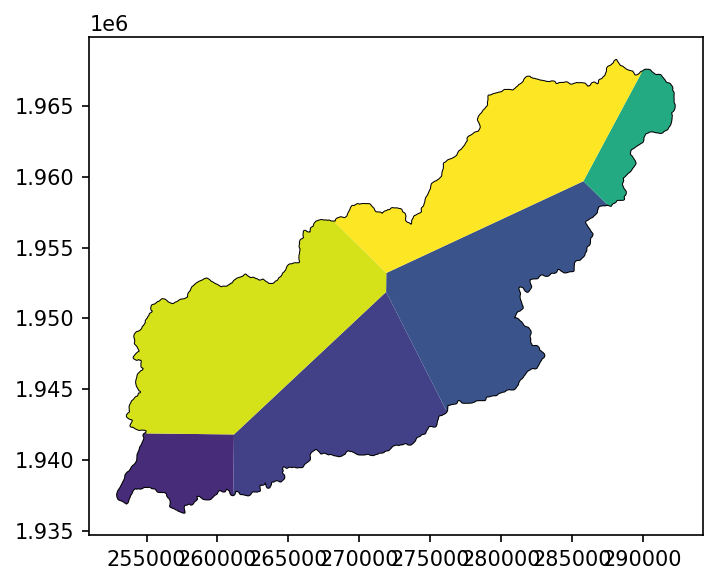

In [6]:
# Áreas de influencia

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 4)
fig.set_dpi(150) 

# Graficamos la cuenca.
Subcuenca.plot(ax = ax, color = "None", edgecolor = "k")
# Graficamos las áreas de influencia.
Estaciones.plot("HP_1980", ax = ax)

fig.tight_layout()
plt.show()